/home/ckarfusehr/anaconda3/envs/gelpy/lib/python3.11/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(


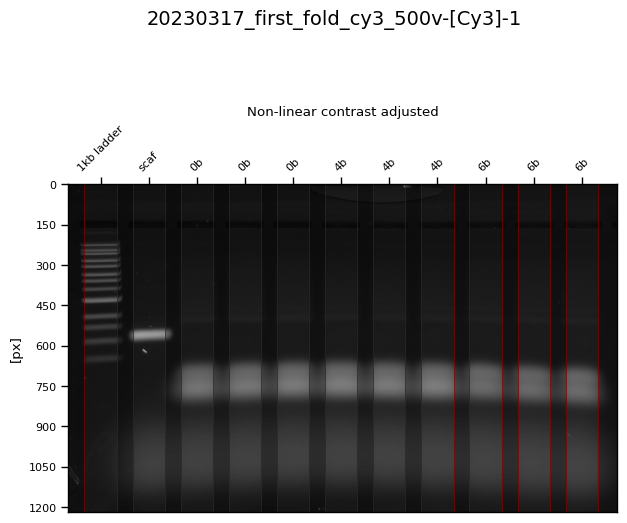

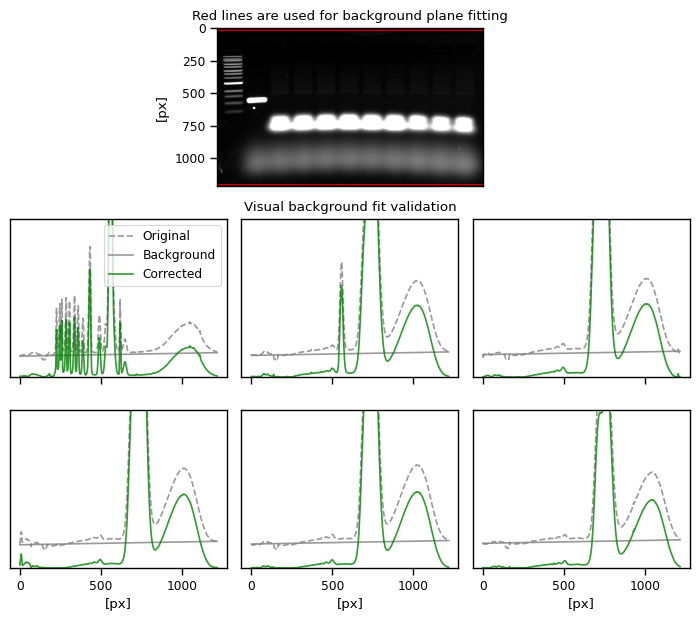

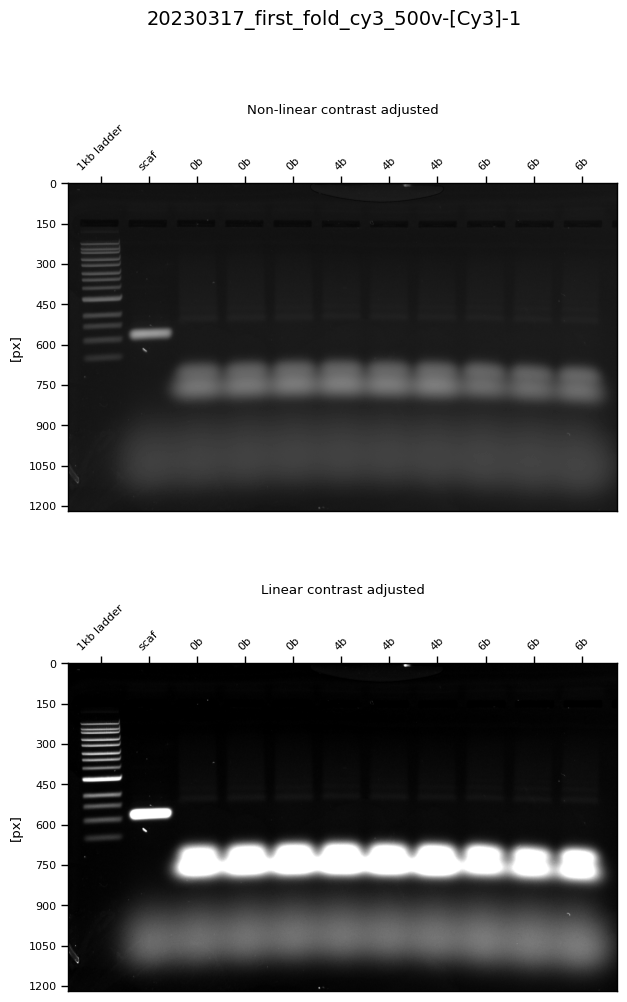

In [1]:
from gelpy import Gel

gel = Gel("data/20230317_first_fold_cy3_500v-[Cy3]-1.tif")
gel.setup_gel(labels=['1kb ladder', 'scaf', '0b', '0b', '0b', '4b', '4b', '4b', '6b', '6b', '6b'],
               x_label_pos=(120, 1910, 11), line_profile_width=120,
               img_height_factor=3, remove_bg=True)
gel.show_adjusted_images()

#gel.remove_background(model="2d_plane_fit")

/home/ckarfusehr/GelPy/gelpy/profile_fitting_models.py:143: RuntimeWarning: overflow encountered in exp
  return amplitude / lambda_ * np.exp(term1) * norm.cdf(term2)
/home/ckarfusehr/GelPy/gelpy/profile_fitting_models.py:143: RuntimeWarning: invalid value encountered in multiply
  return amplitude / lambda_ * np.exp(term1) * norm.cdf(term2)
/home/ckarfusehr/GelPy/gelpy/profile_fitting_models.py:143: RuntimeWarning: overflow encountered in multiply
  return amplitude / lambda_ * np.exp(term1) * norm.cdf(term2)


,selected_lane_index,label,band_number,relative_area,maxima_position,Amplitude,Mean,Standard Deviation,Lambda
0,0,1kb ladder,0,0.043,126.264,0.041,127.758,2.030,2.221
1,0,1kb ladder,1,0.055,146.418,0.052,148.335,1.671,4.363
2,0,1kb ladder,2,0.069,159.351,0.066,161.343,1.790,4.374
3,0,1kb ladder,3,0.077,185.693,0.074,187.899,1.982,4.828
4,0,1kb ladder,4,0.074,206.419,0.071,208.702,2.397,4.171
5,0,1kb ladder,5,0.086,236.829,0.083,239.240,2.738,4.088
6,0,1kb ladder,6,0.074,259.534,0.071,261.899,3.173,3.534
7,0,1kb ladder,7,0.059,289.582,0.057,291.873,3.935,2.989
8,0,1kb ladder,8,0.209,332.326,0.200,335.303,4.061,4.399
9,0,1kb ladder,9,0.082,390.678,0.079,392.473,5.820,1.920


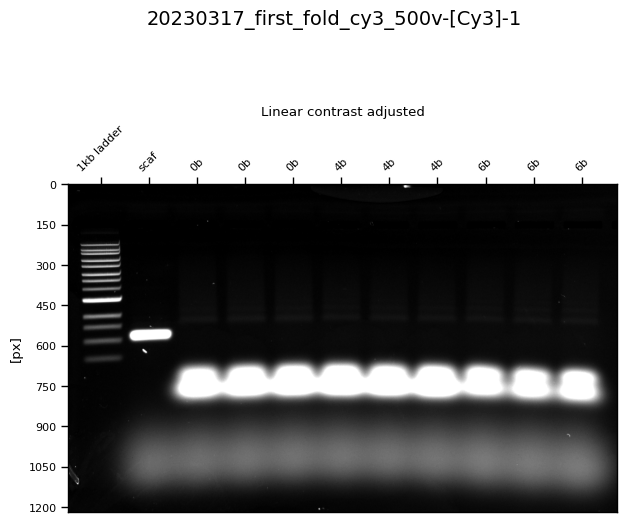

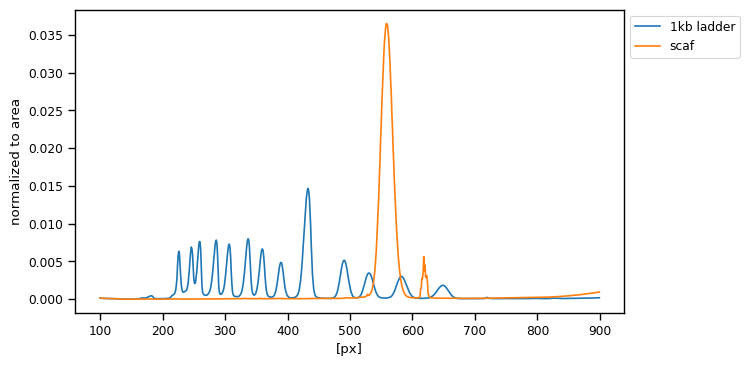

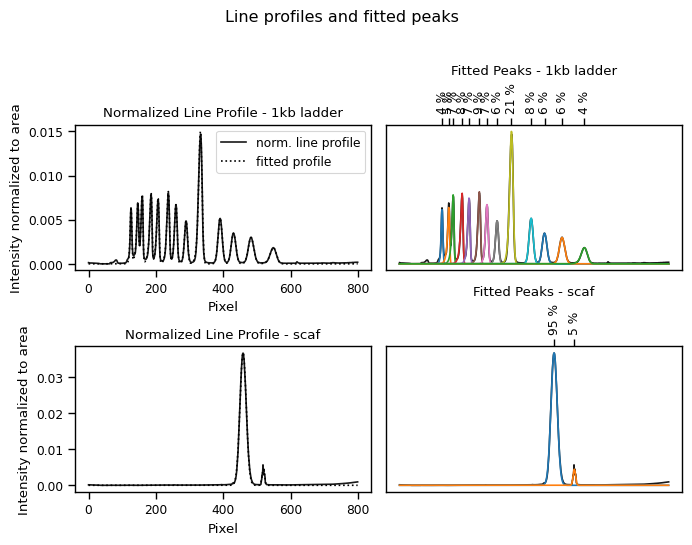

In [4]:

gel.show_adjusted_images(show_type="linear")
gel.show_line_profiles(select_lanes=[0,1],
                       slice_line_profile_length=(100, 900),
                       fit=True,
                       sigma=2,
                       plot_fits=True)